# UMAPs Neurips samples, NK cells

In this notebook different markers to identify NK cell subpopulations are tested. Markers are collected from Melsen et al., paper (2022). RNA and corresponding surface markers are shown when available. Protein expression levels within a cell are normalized using the centered-log ratio (CLR) transformation. UMAPs are generated from latent space, CLR normalized protein counts or RNA expression. 



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



In [13]:
#Neurips
adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [14]:
#To find gene names

result = [i for i in adata_neurips.var_names if i.startswith('TC')]
print(result)

['TC2N', 'TCAF1', 'TCAF2', 'TCAIM', 'TCAP', 'TCEA1', 'TCEA2', 'TCEA3', 'TCEAL1', 'TCEAL2', 'TCEAL3', 'TCEAL4', 'TCEAL5', 'TCEAL7', 'TCEAL8', 'TCEAL9', 'TCEANC', 'TCEANC2', 'TCEB1', 'TCEB2', 'TCEB3', 'TCEB3-AS1', 'TCERG1', 'TCF12', 'TCF15', 'TCF19', 'TCF20', 'TCF23', 'TCF25', 'TCF3', 'TCF4', 'TCF4-AS2', 'TCF7', 'TCF7L1', 'TCF7L2', 'TCFL5', 'TCHH', 'TCHP', 'TCIRG1', 'TCL1A', 'TCL1B', 'TCL6', 'TCN2', 'TCOF1', 'TCP1', 'TCP10L', 'TCP11', 'TCP11L1', 'TCP11L2', 'TCTA', 'TCTE1', 'TCTE3', 'TCTEX1D1', 'TCTEX1D2', 'TCTEX1D4', 'TCTN1', 'TCTN2', 'TCTN3']


In [15]:
#Both NK cell types selected

neurips_nk = adata_neurips[(adata_neurips.obs['cell_type'] == "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]

In [16]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [17]:
neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [18]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]

In [19]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [39]:
#selecting one sample from Neurips

eg=adata_neurips[adata_neurips.obs['POOL'] == "s1d2"]


In [40]:
eg

View of AnnData object with n_obs × n_vars = 4450 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [41]:
prot=eg.obsm['protein_expression_clr_neurips']

In [42]:
#some proteins and genes have same names, here _prot added after protein names
prot=prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})


In [43]:
#adding protein information to obs

a = eg.obs
b = prot

adata_eg=pd.concat([a, b], axis=1)
eg.obs=adata_eg


In [44]:
eg

AnnData object with n_obs × n_vars = 4450 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

In [45]:
#selecting NK cells, gd T cells and ILCs

sample_nk = eg[(eg.obs['cell_type'] == "NK") | (eg.obs['cell_type'] == "NK CD158e1+")]   


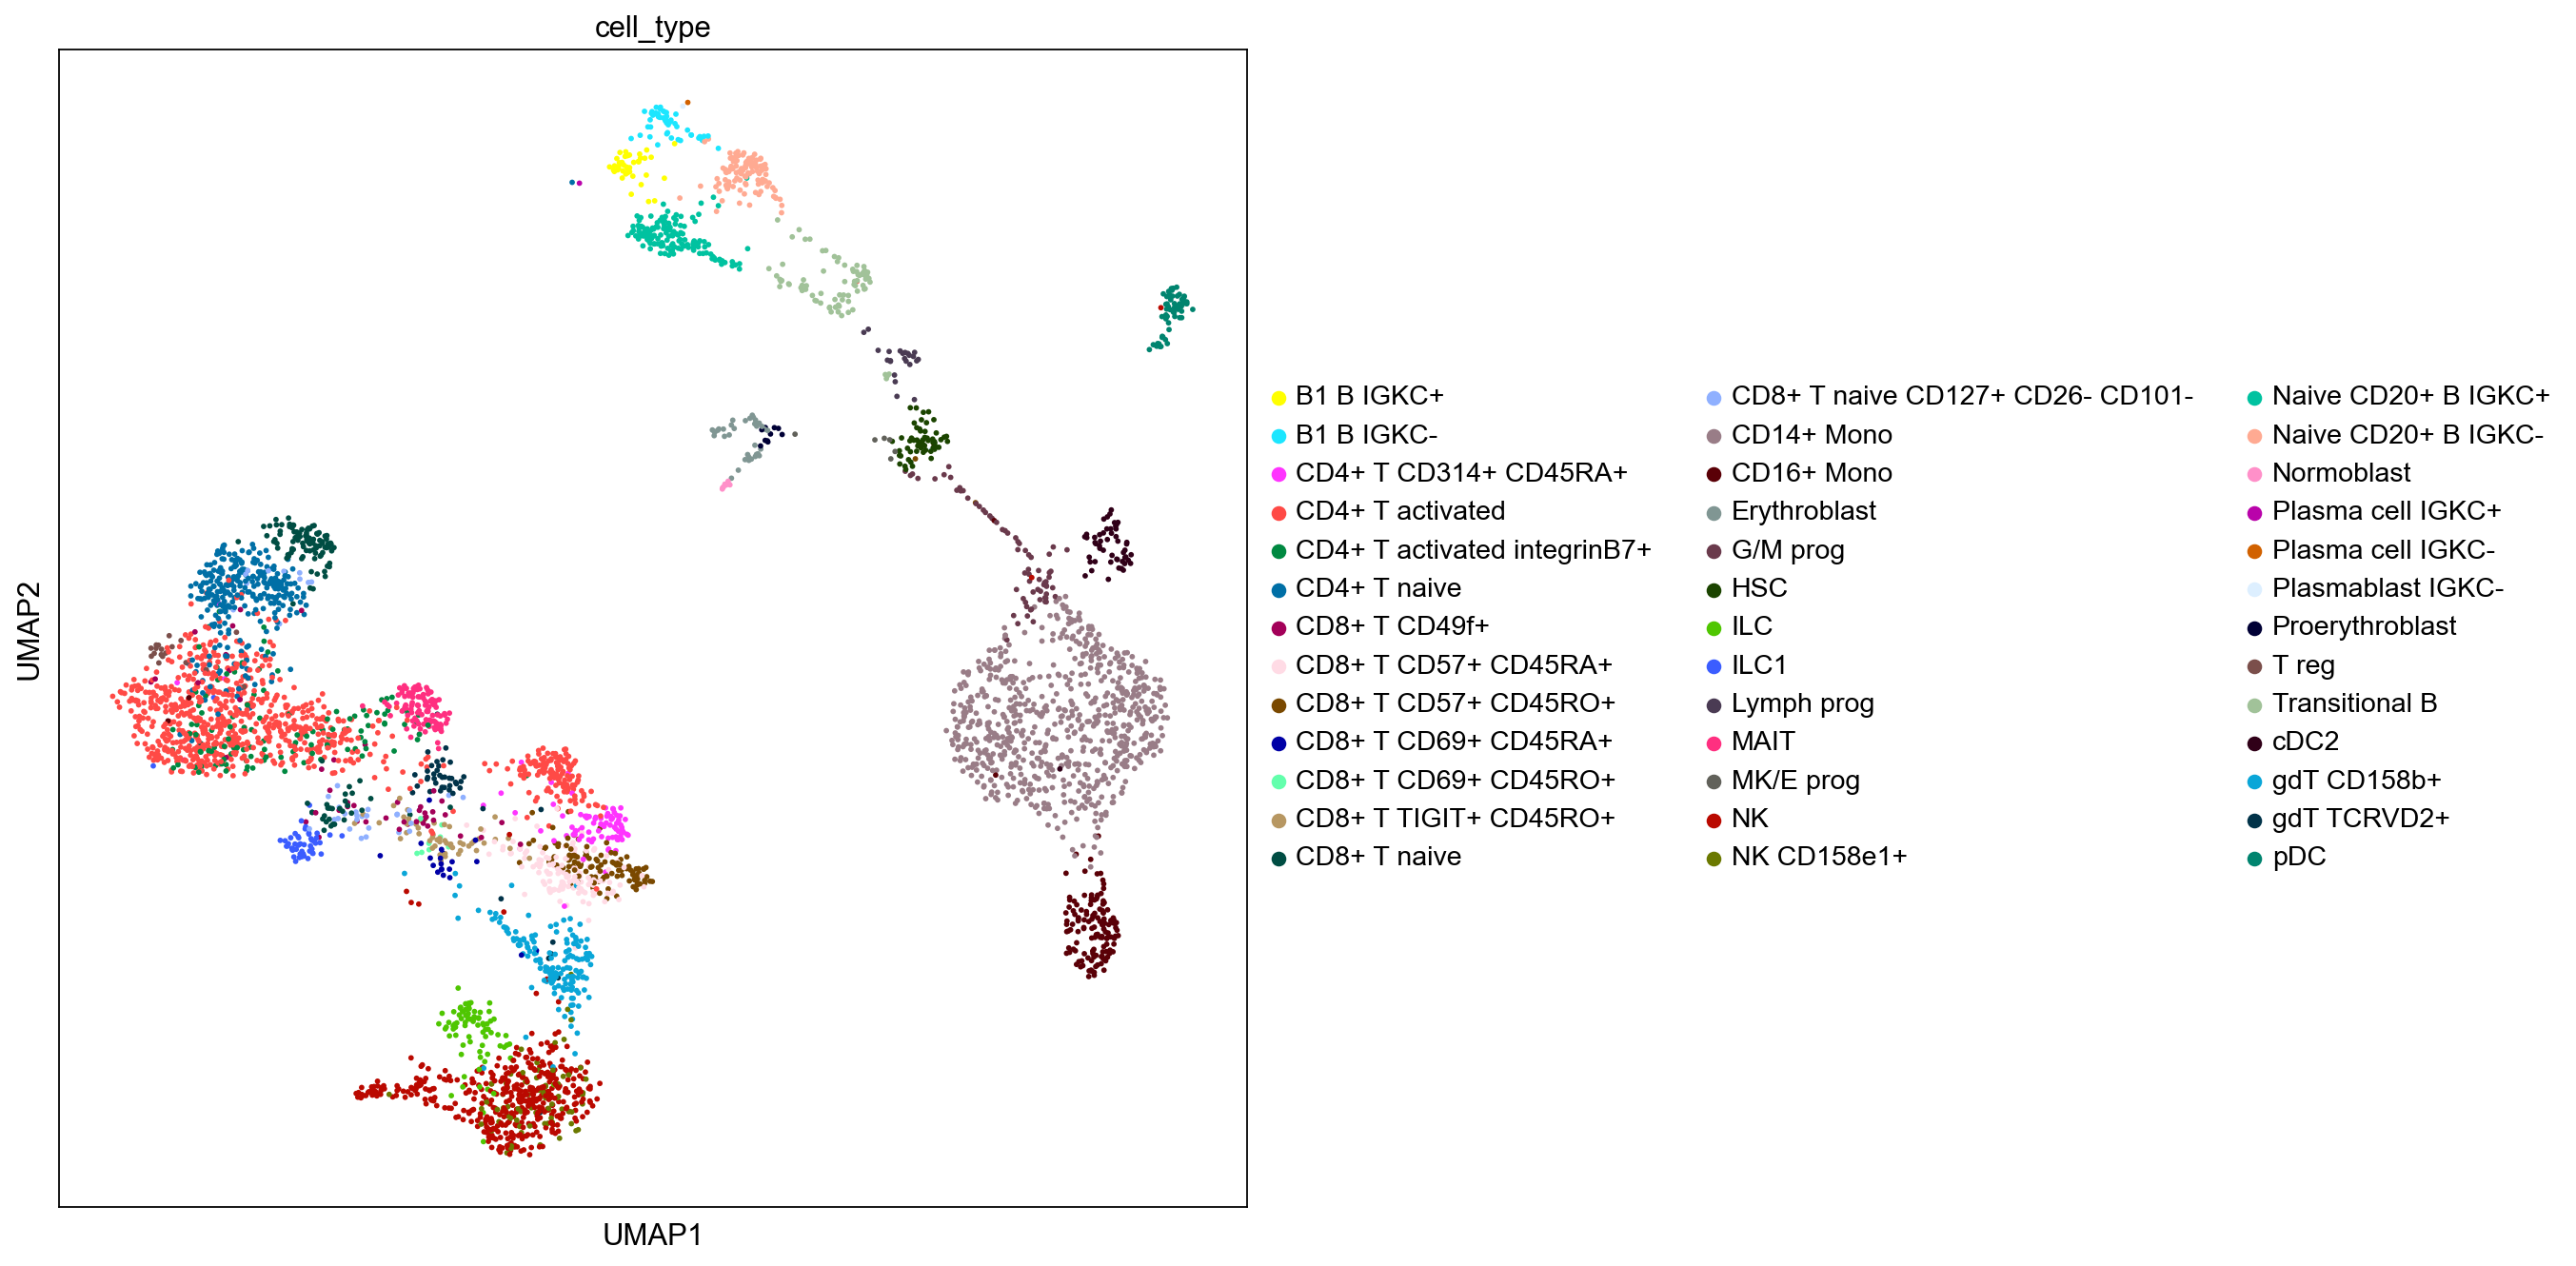

In [46]:
#Only selected sample

sc.set_figure_params(figsize=(10, 10))


sc.pl.umap(eg, color = ['cell_type'], color_map = 'viridis')

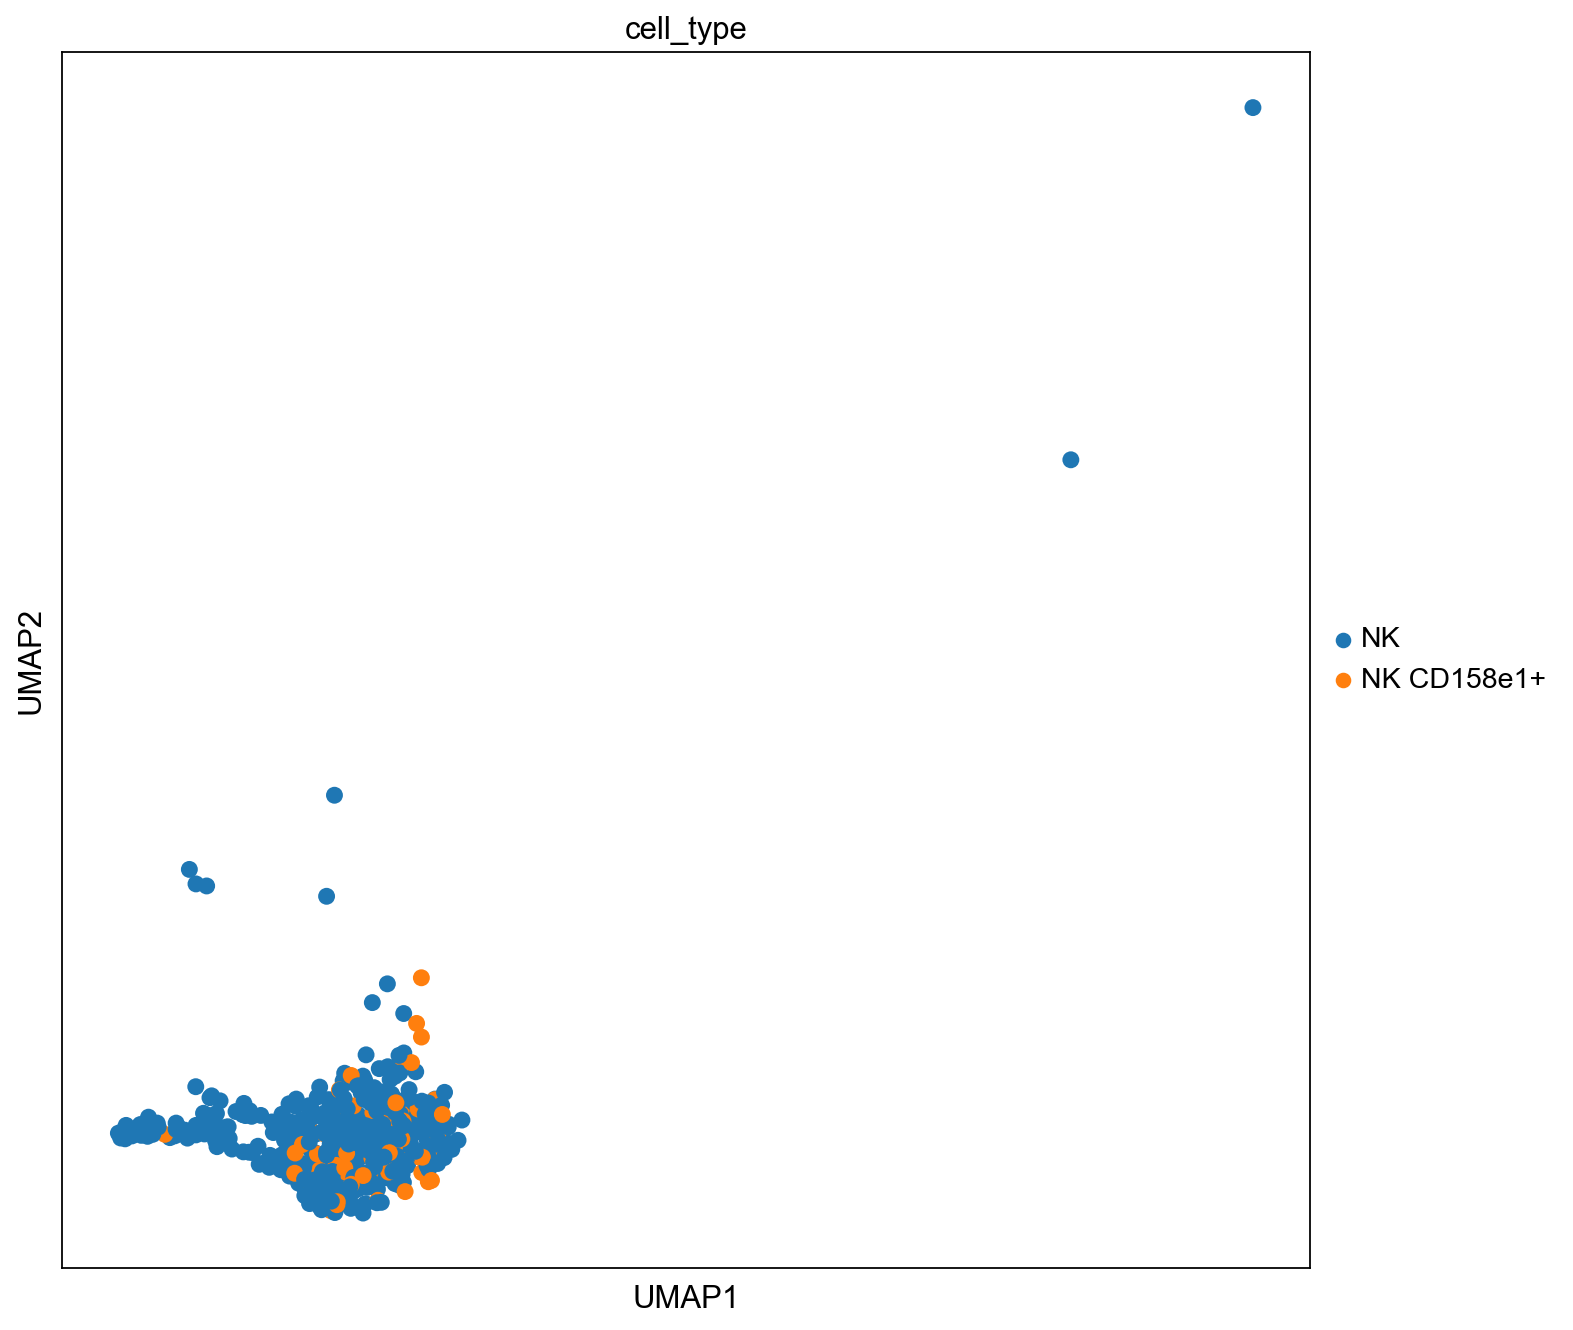

In [47]:
#NK, gd T cells and ILCs from selected sample

sc.pl.umap(sample_nk, color = ['cell_type'], color_map = 'viridis')

In [48]:
#selecting one sample from Neurips

eg=adata_neurips[adata_neurips.obs['POOL'] == "s4d1"]

In [49]:
#Computing a neighborhood of observations using latent space, before subsetting the data

sc.pp.neighbors(sample_nk, use_rep="X_totalVI")   #indicated representation

sc.tl.umap(sample_nk)

In [50]:
sample_nk

AnnData object with n_obs × n_vars = 518 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25', 

In [10]:
#Used to check which markers were measured


#listOfmarkers= ['CD160']


#for x in listOfmarkers:
#    if x in prot.columns:
#        print(x)


# Protein vs RNA

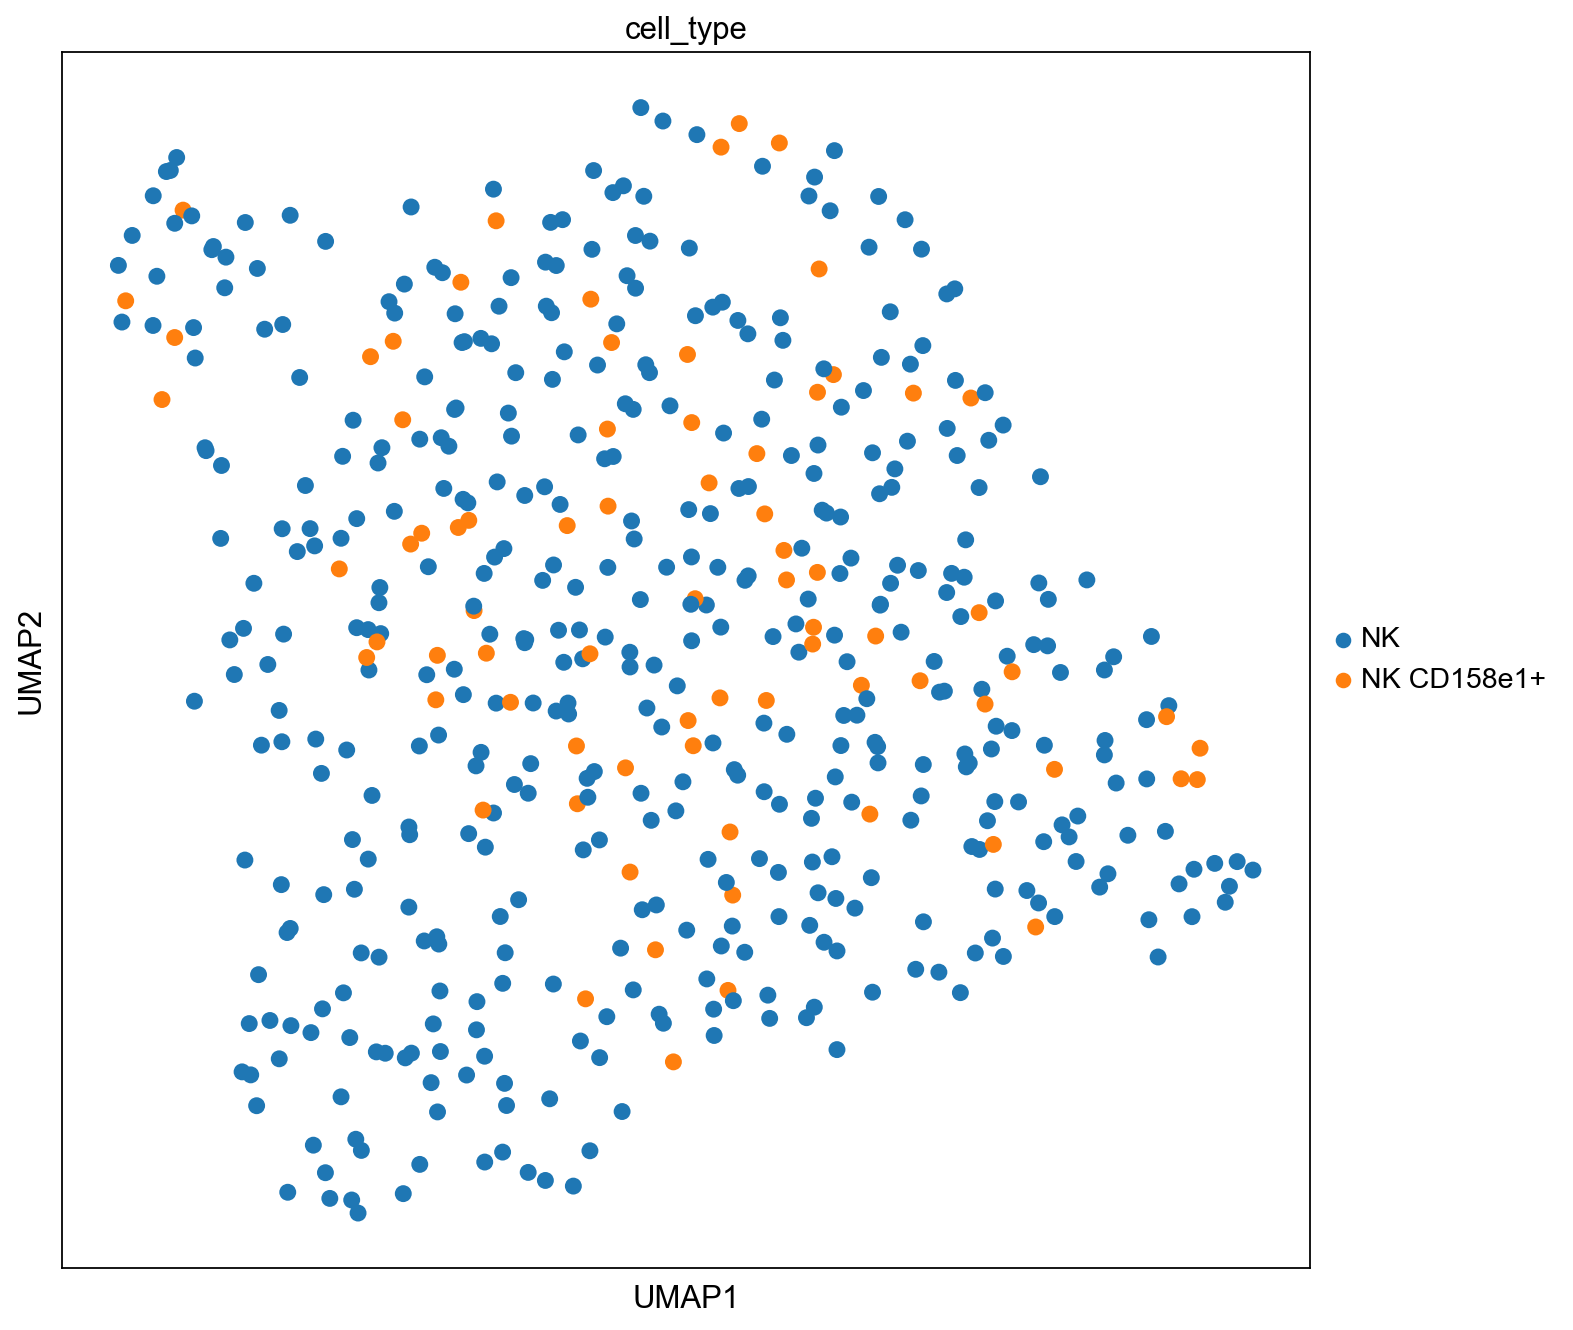

lymphoid tissue-resident NK cells, RNA


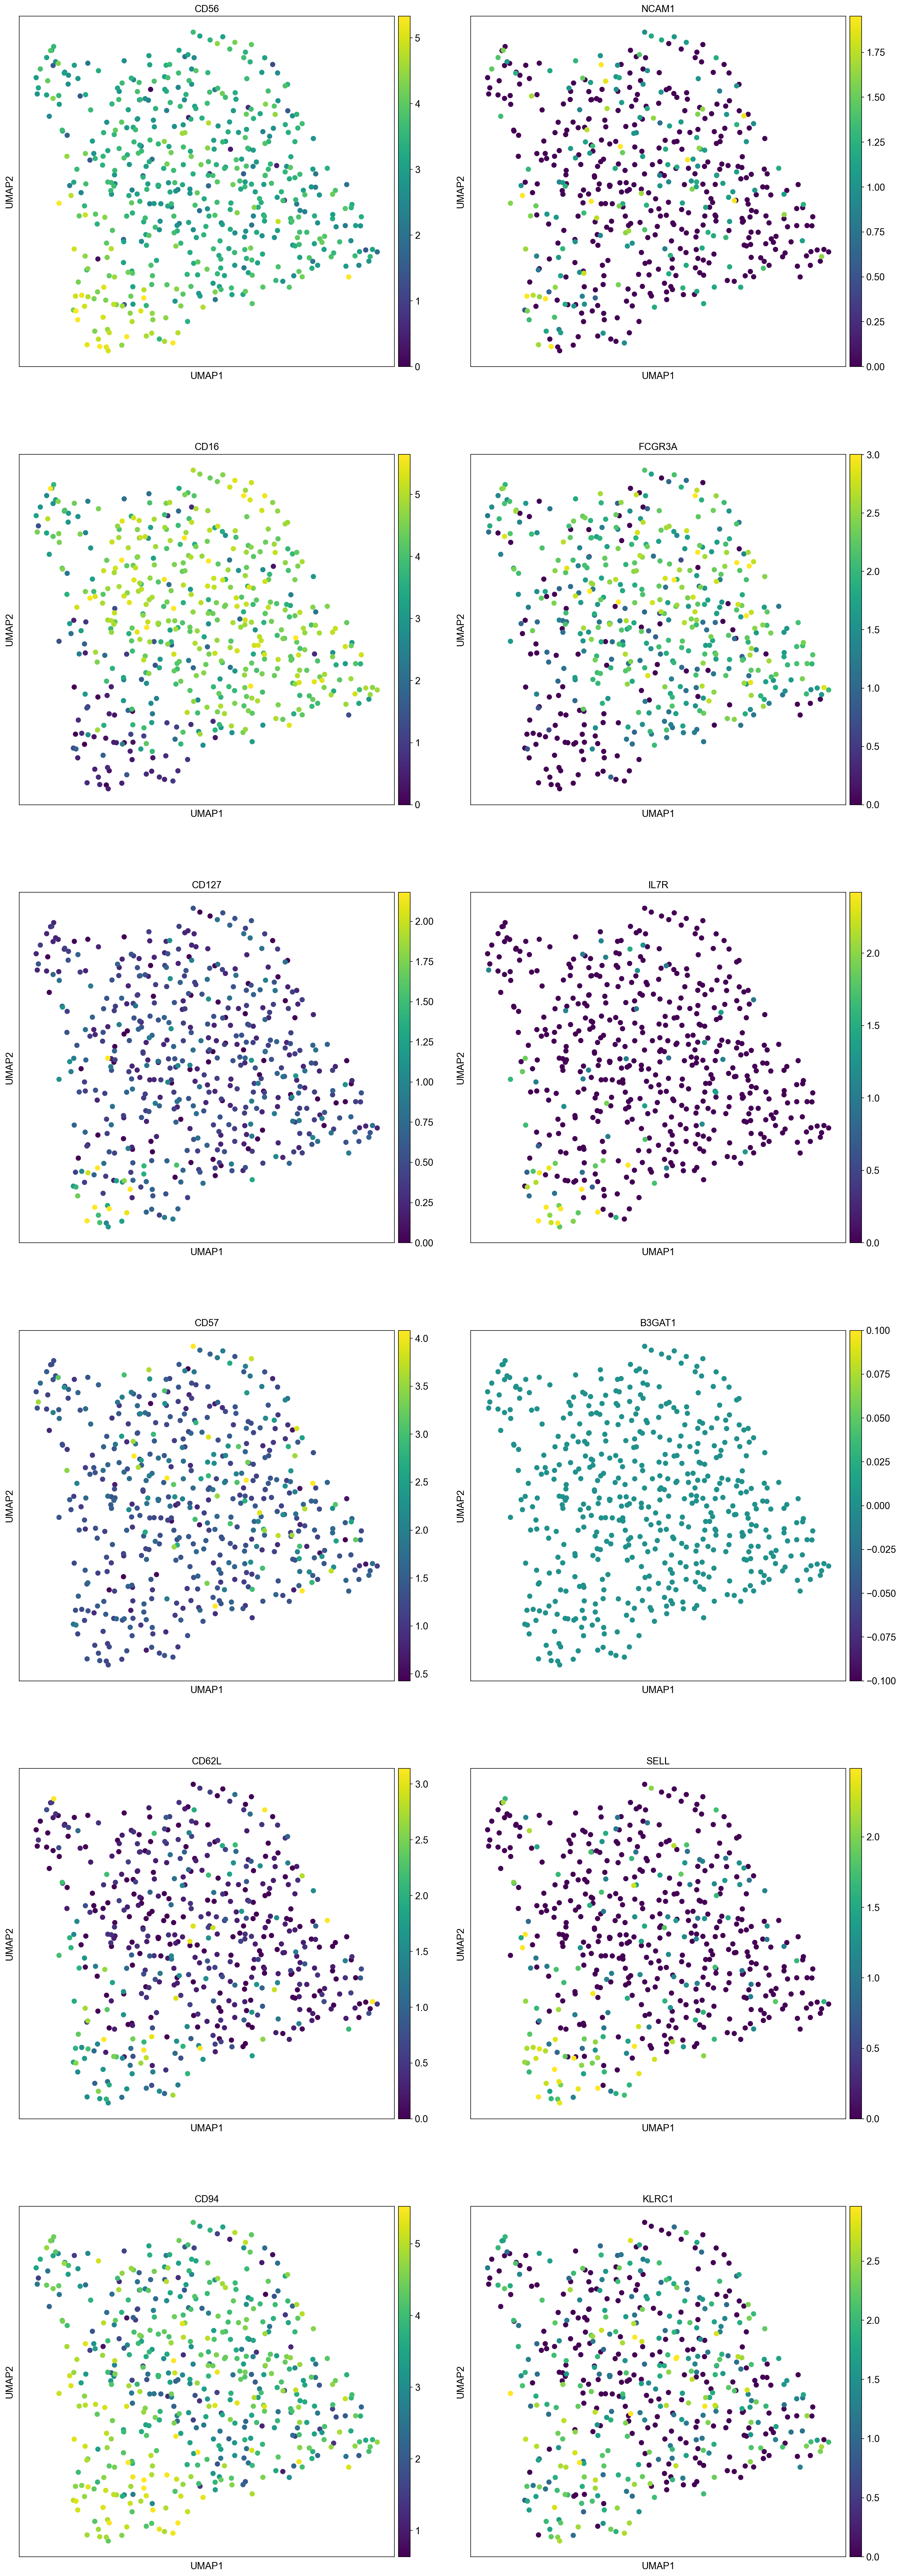

In [51]:
markers= ['CD56', 'NCAM1', 'CD16','FCGR3A', 'CD127', 'IL7R', 'CD57', 'B3GAT1', 'CD62L','SELL', 'CD94', 'KLRC1']

sc.pl.umap(sample_nk, color = ['cell_type'], color_map = 'viridis')

#RNA
print('lymphoid tissue-resident NK cells, RNA')
sc.pl.umap(sample_nk, color = markers, vmax="p99", color_map = 'viridis', ncols=2)


In [148]:
X = neurips_nk.to_df()

In [149]:
X.shape

(7388, 21720)

In [150]:
prot_nk = neurips_nk.obsm['protein_expression_clr_neurips']

In [151]:
prot_nk

CD86     CD274     CD270     CD155     CD112  \
GTAGTACCAATCCTTT-1-s4d1  0.652674  1.447594  1.489354  0.890243  1.290341   
CTGTGGGTCATGCGGC-1-s4d1  0.378666  1.132949  1.153412  0.730824  1.195368   
GCAACATTCGCAAGAG-1-s4d1  0.378666  1.192753  1.208881  0.000000  1.456877   
TCACGGGTCGCACGAC-1-s4d1  0.000000  0.849902  1.548700  0.730824  1.530781   
CGCCAGAAGACCATTC-1-s4d1  0.652674  1.249182  1.404314  0.306698  1.417770   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  0.000000  0.568367  1.124479  1.027708  0.600556   
ACATTTCCAGCAGTGA-1-s1d3  0.000000  0.671273  0.856802  0.000000  0.284617   
TGAGACTTCCTTCAGC-1-s1d3  0.000000  0.671273  0.734526  0.306698  0.284617   
GAGATGGTCCGCCTAT-1-s1d3  0.000000  0.928521  0.999570  0.541080  0.600556   
ACCTGTCTCACAGTGT-1-s1d3  0.652674  0.175083  0.856802  0.000000  0.284617   

                             CD47      CD48      CD40     CD154      CD52  \
GTAGTACCAATCCTTT-1-s4d1  1.988618  1.733474  0.850004  1.531390  0.694828   
CTGTGGGTCATGCGGC-1-s4d1  1.546005  1.090567  1.173337  1.303511  1.013739   
GCAACATTCGCAAGAG-1-s4d1  1.046035  1.333993  0.638218  1.360894  1.072649   
TCACGGGTCGCACGAC-1-s4d1  1.883102  1.686271  1.240123  1.804089  0.812797   
CGCCAGAAGACCATTC-1-s4d1  1.664855  1.409627  1.302726  1.663363  0.849218   
...                           ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  2.007513  1.679342  0.749707  0.545181  0.288523   
ACATTTCCAGCAGTGA-1-s1d3  1.105431  0.818721  0.201533  0.309292  0.652195   
TGAGACTTCCTTCAGC-1-s1d3  1.255114  1.174628  0.749707  0.625887  0.406586   
GAGATGGTCCGCCTAT-1-s1d3  1.759143  2.420602  1.024682  0.700563  0.406586   
ACCTGTCTCACAGTGT-1-s1d3  1.193686  0.866867  0.512721  0.457384  0.775000   

                         ...     HLA-E      CD82     CD101      CD88  \
GTAGTACCAATCCTTT-1-s4d1  ...  1.532575  0.614600  0.900688  1.389844   
CTGTGGGTCATGCGGC-1-s4d1  ...  1.344431  0.353792  0.860303  0.979461   
GCAACATTCGCAAGAG-1-s4d1  ...  1.218539  0.670407  0.329073  1.280509   
TCACGGGTCGCACGAC-1-s4d1  ...  1.456232  0.614600  0.576253  1.189870   
CGCCAGAAGACCATTC-1-s4d1  ...  1.556781  0.276377  0.680162  1.415407   
...                      ...       ...       ...       ...       ...   
ATCATTCGTCCAATCA-1-s1d3  ...  1.556781  0.353792  0.519947  0.809714   
ACATTTCCAGCAGTGA-1-s1d3  ...  0.950948  0.555495  0.519947  0.546717   
TGAGACTTCCTTCAGC-1-s1d3  ...  0.374154  0.492675  0.396827  0.418509   
GAGATGGTCCGCCTAT-1-s1d3  ...  1.532575  0.555495  0.576253  0.546717   
ACCTGTCTCACAGTGT-1-s1d3  ...  0.758186  0.276377  0.396827  0.418509   

                            CD224  CD197  CD34  CD10  CD90  CD15  
GTAGTACCAATCCTTT-1-s4d1  0.918109    0.0   0.0   0.0   0.0   0.0  
CTGTGGGTCATGCGGC-1-s4d1  1.147198    0.0   0.0   0.0   0.0   0.0  
GCAACATTCGCAAGAG-1-s4d1  0.676616    0.0   0.0   0.0   0.0   0.0  
TCACGGGTCGCACGAC-1-s4d1  1.000442    0.0   0.0   0.0   0.0   0.0  
CGCCAGAAGACCATTC-1-s4d1  0.729806    0.0   0.0   0.0   0.0   0.0  
...                           ...    ...   ...   ...   ...   ...  
ATCATTCGTCCAATCA-1-s1d3  0.357584    0.0   0.0   0.0   0.0   0.0  
ACATTTCCAGCAGTGA-1-s1d3  0.194691    0.0   0.0   0.0   0.0   0.0  
TGAGACTTCCTTCAGC-1-s1d3  0.000000    0.0   0.0   0.0   0.0   0.0  
GAGATGGTCCGCCTAT-1-s1d3  0.430053    0.0   0.0   0.0   0.0   0.0  
ACCTGTCTCACAGTGT-1-s1d3  0.780309    0.0   0.0   0.0   0.0   0.0  

[7388 rows x 139 columns]

In [170]:
#To exclude columns that contain only zeros

#prot_nk = pd.DataFrame(prot_nk)
prot_nk != 0
(prot_nk != 0).any(axis=0)
prot_nk.loc[:, (prot_nk != 0).any(axis=0)]
prot_nk = prot_nk.loc[:, (prot_nk != 0).any(axis=0)]

In [171]:
df_comb = pd.concat([X,prot_nk], axis=1)


In [172]:
X.shape

(7388, 21720)

In [174]:
df_comb.shape

(7388, 21854)

In [175]:
df_comb_cd16=df_comb.sort_values(by='CD16', ascending=True)

In [176]:
df_comb_cd16['CD16']

ACCTGTCTCACAGTGT-1-s1d3    0.000000
CACAGGCGTTTCTATC-1-s3d7    0.000000
TTGCTGCAGTTGGAAT-1-s3d7    0.000000
CGCATGGCAGGTCAAG-1-s3d7    0.000000
TGACGCGTCAAGAGGC-1-s3d7    0.000000
                             ...   
TCACTATTCAGACAAA-1-s4d8    6.126854
GTGAGGATCTGGAGAG-1-s4d8    6.163776
GTTAGACAGCAACAAT-1-s4d8    6.217732
AACAAAGAGAAACTGT-1-s4d8    6.232439
GGAGCAACAATCCTTT-1-s4d8    7.900404
Name: CD16, Length: 7388, dtype: float64

Text(0.5, 0, 'CD56')

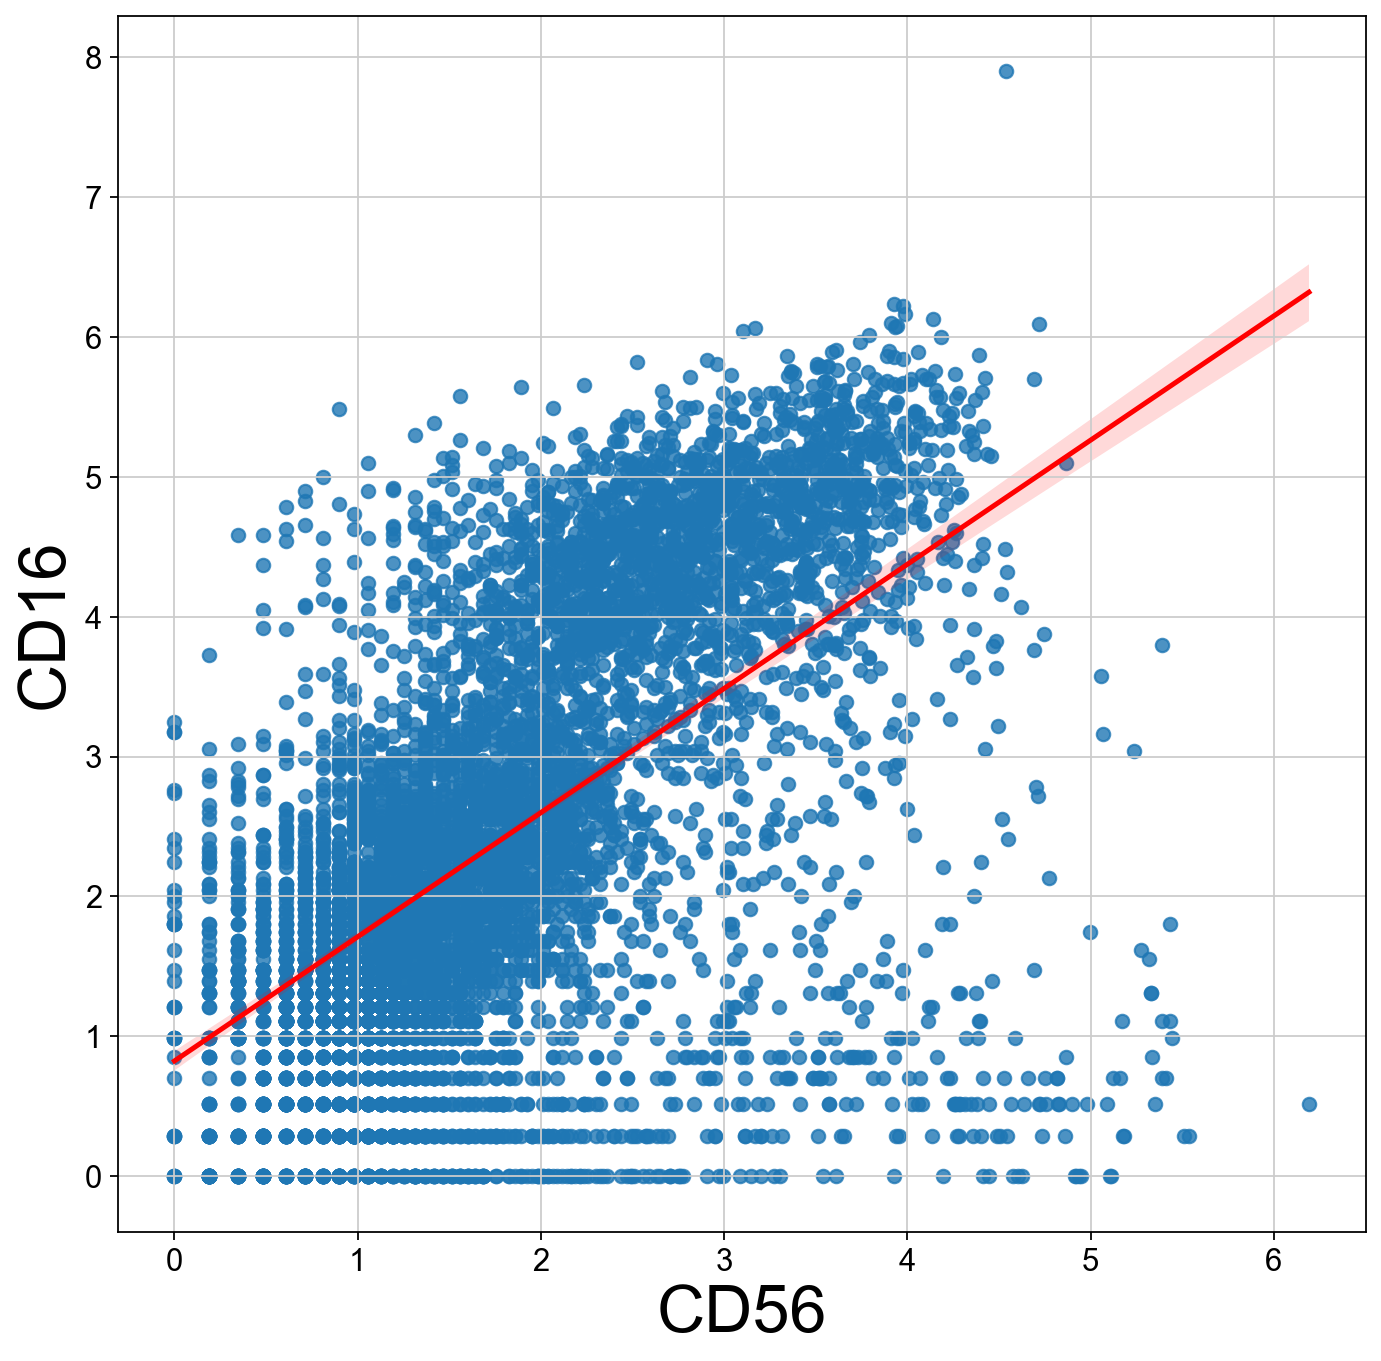

In [182]:
a = sns.regplot(data=df_comb_cd16, x='CD56' , y='CD16', 
                line_kws = {"color": "red"})
a.set_ylabel("CD16",fontsize=30)
a.set_xlabel("CD56",fontsize=30)

Text(0.5, 0, 'FCGR3A')

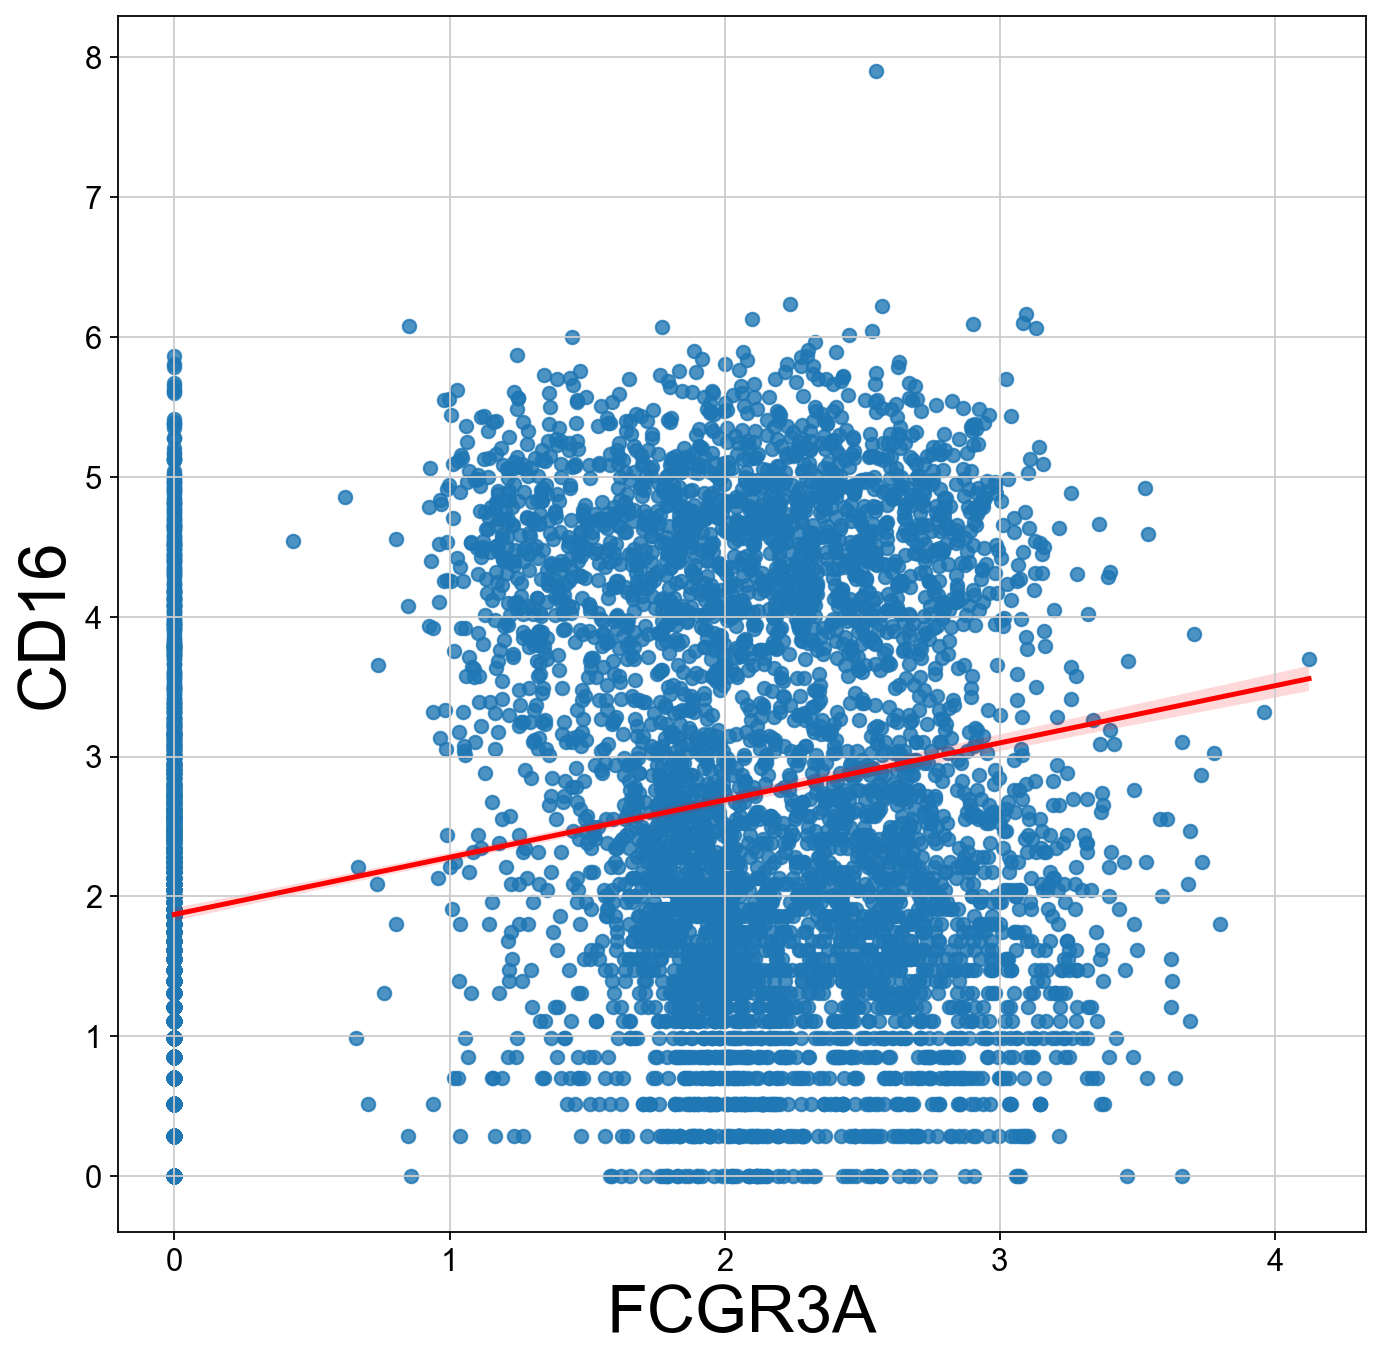

In [183]:
a = sns.regplot(data=df_comb_cd16, x='FCGR3A' , y='CD16', 
                line_kws = {"color": "red"})
a.set_ylabel("CD16",fontsize=30)
a.set_xlabel("FCGR3A",fontsize=30)

Text(0.5, 0, 'GZMK')

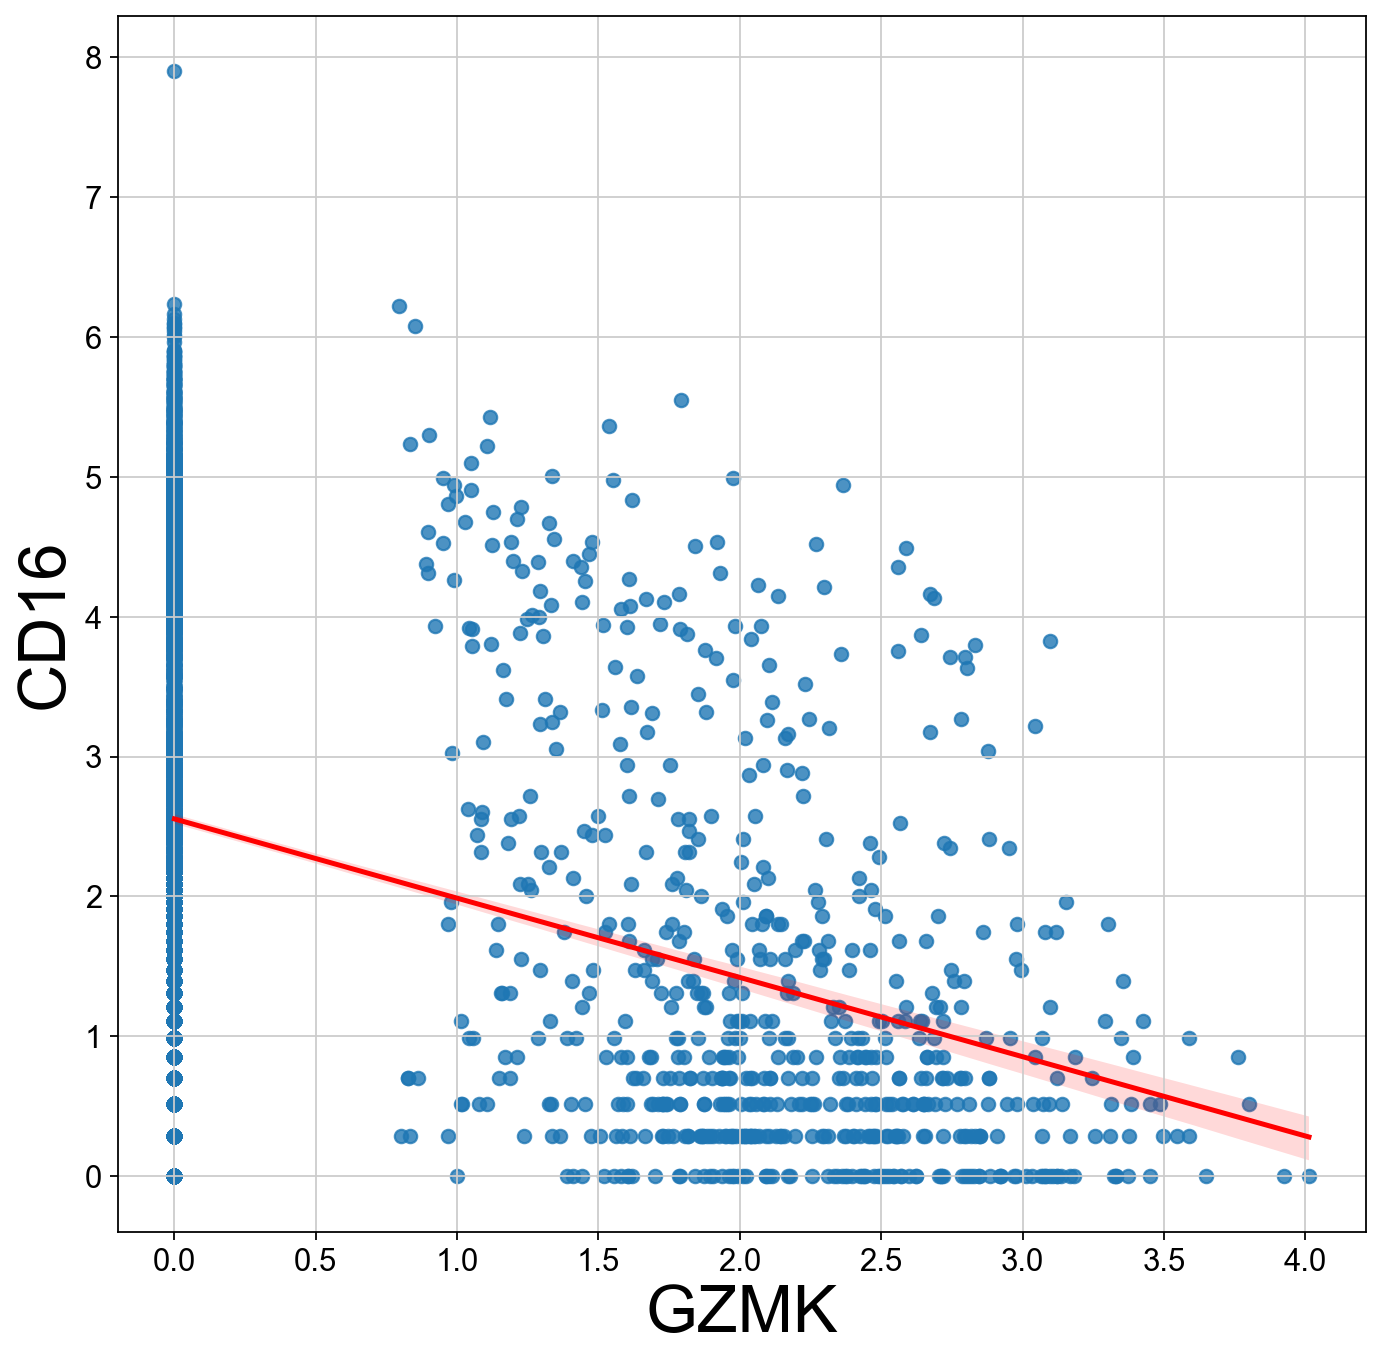

In [184]:
a = sns.regplot(data=df_comb_cd16, x='GZMK' , y='CD16', 
                line_kws = {"color": "red"})
a.set_ylabel("CD16",fontsize=30)
a.set_xlabel("GZMK",fontsize=30)

In [163]:
df_comb_cd56=df_comb.sort_values(by='CD56', ascending=True)

In [164]:
df_comb_cd56['CD56']

TCGCAGGTCCTACAAG-1-s2d1    0.000000
CTGTACCAGGGCAACT-1-s3d7    0.000000
CGGGTGTCATGGGCAA-1-s2d1    0.000000
GCCGATGAGTCCTGTA-1-s2d1    0.000000
GACCAATTCAGACTGT-1-s2d5    0.000000
                             ...   
CCGGACAGTCCTACAA-1-s1d2    5.434825
TGTGCGGTCTACACAG-1-s1d2    5.443877
TCGACCTAGCCTATCA-1-s1d3    5.510115
GTTGCGGCAGACACCC-1-s1d3    5.534277
CCGTAGGTCCCTCAAC-1-s1d3    6.191045
Name: CD56, Length: 7388, dtype: float64

Text(0.5, 0, 'GZMB')

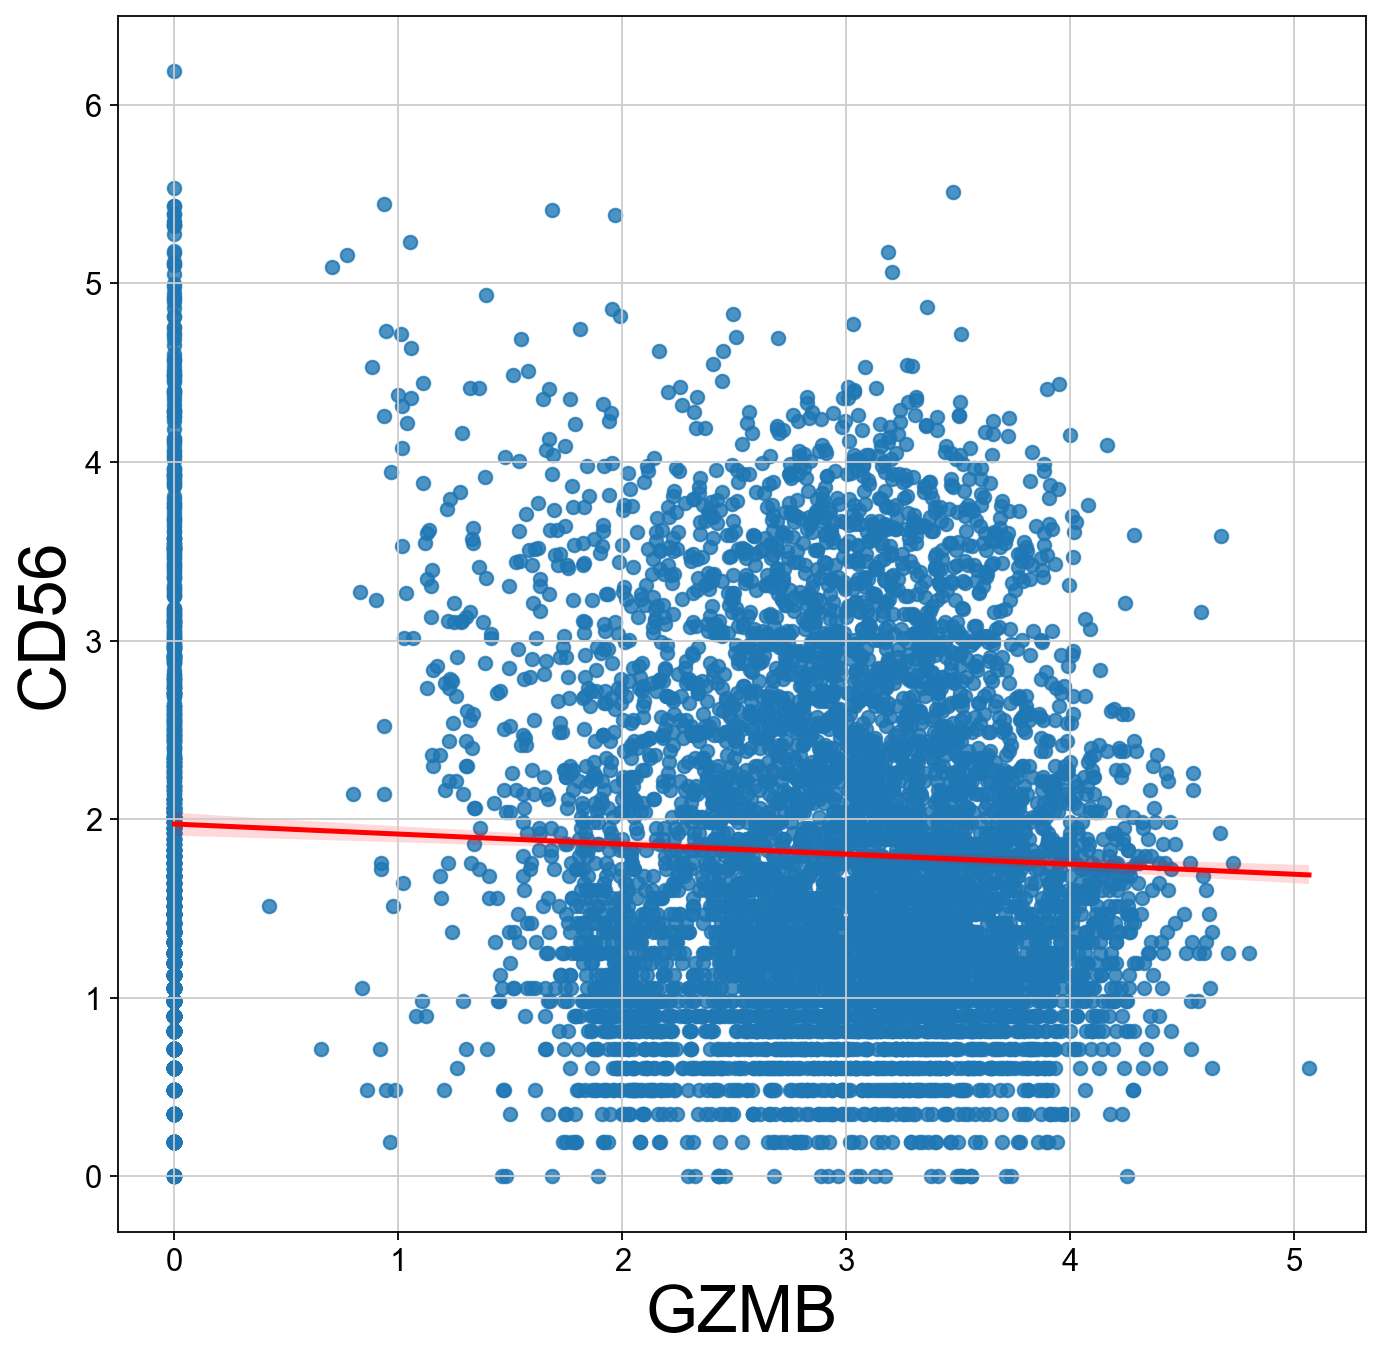

In [185]:
a = sns.regplot(data=df_comb_cd16, x='GZMB' , y='CD56', 
                line_kws = {"color": "red"})
a.set_ylabel("CD56",fontsize=30)
a.set_xlabel("GZMB",fontsize=30)

Text(0.5, 0, 'GZMK')

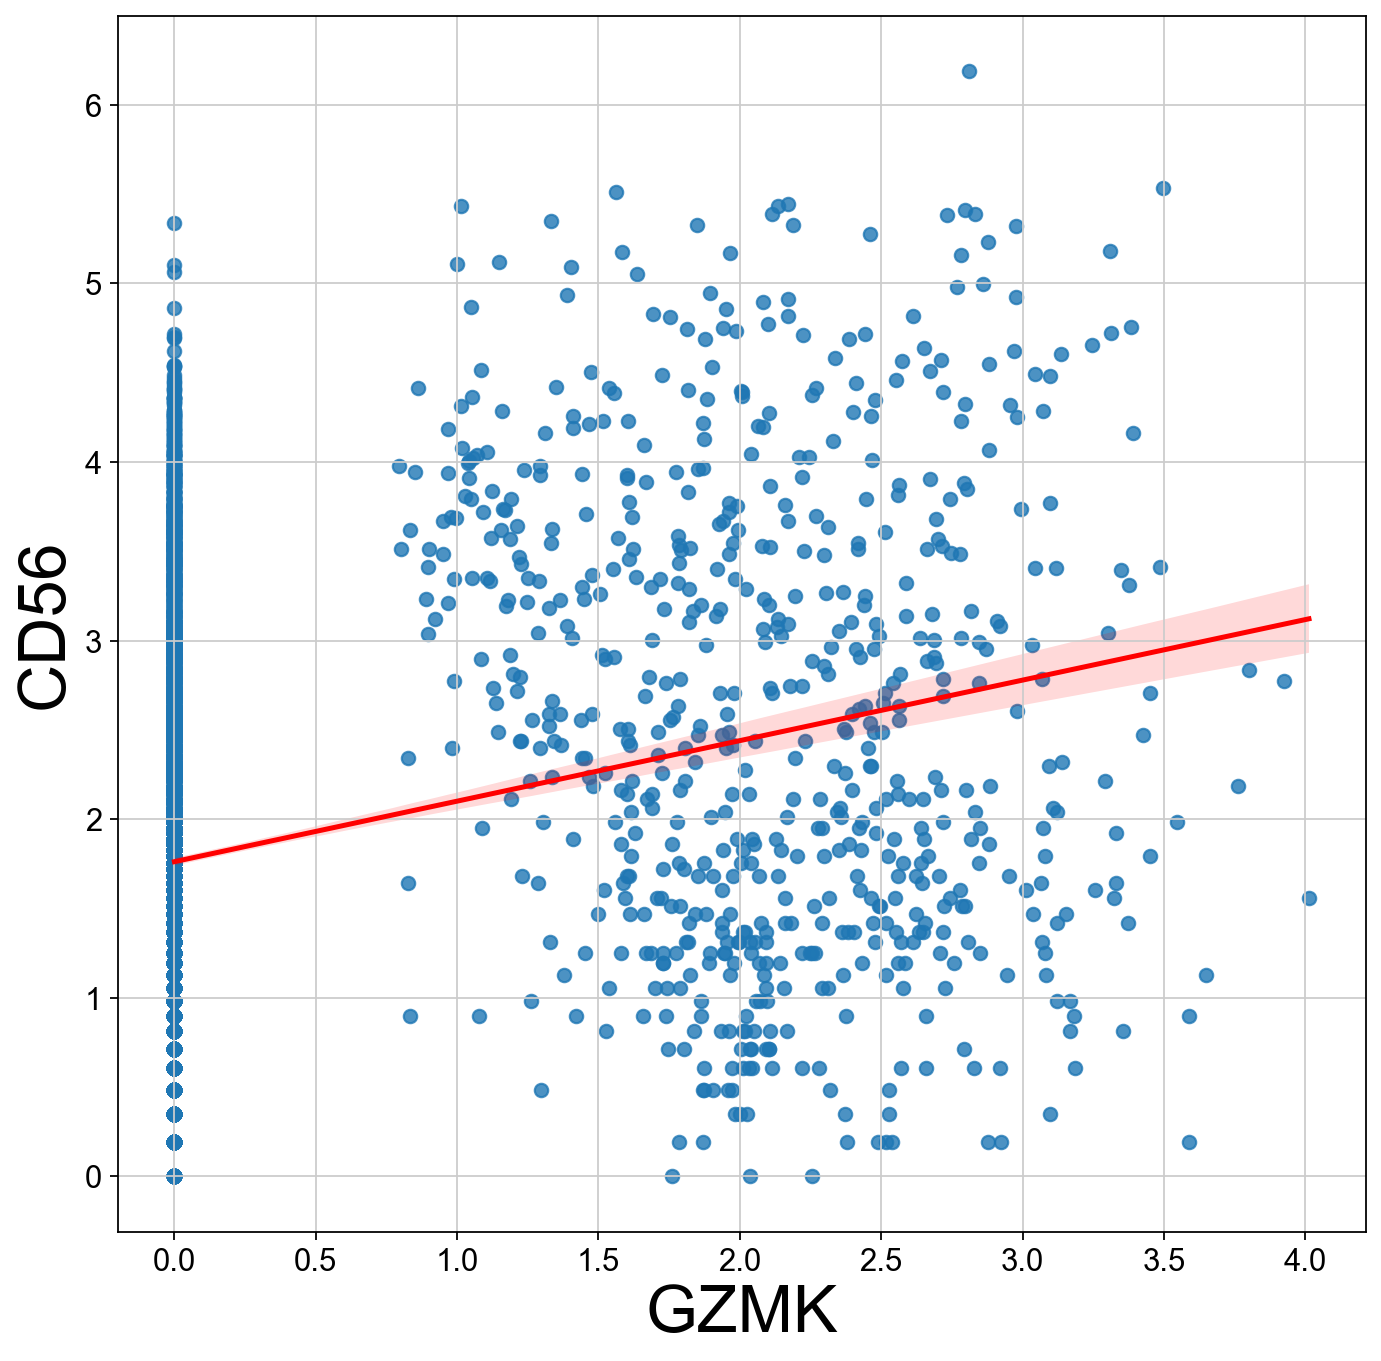

In [187]:
a = sns.regplot(data=df_comb_cd16, x='GZMK' , y='CD56', 
                line_kws = {"color": "red"})
a.set_ylabel("CD56",fontsize=30)
a.set_xlabel("GZMK",fontsize=30)

Text(0.5, 0, 'NCAM1')

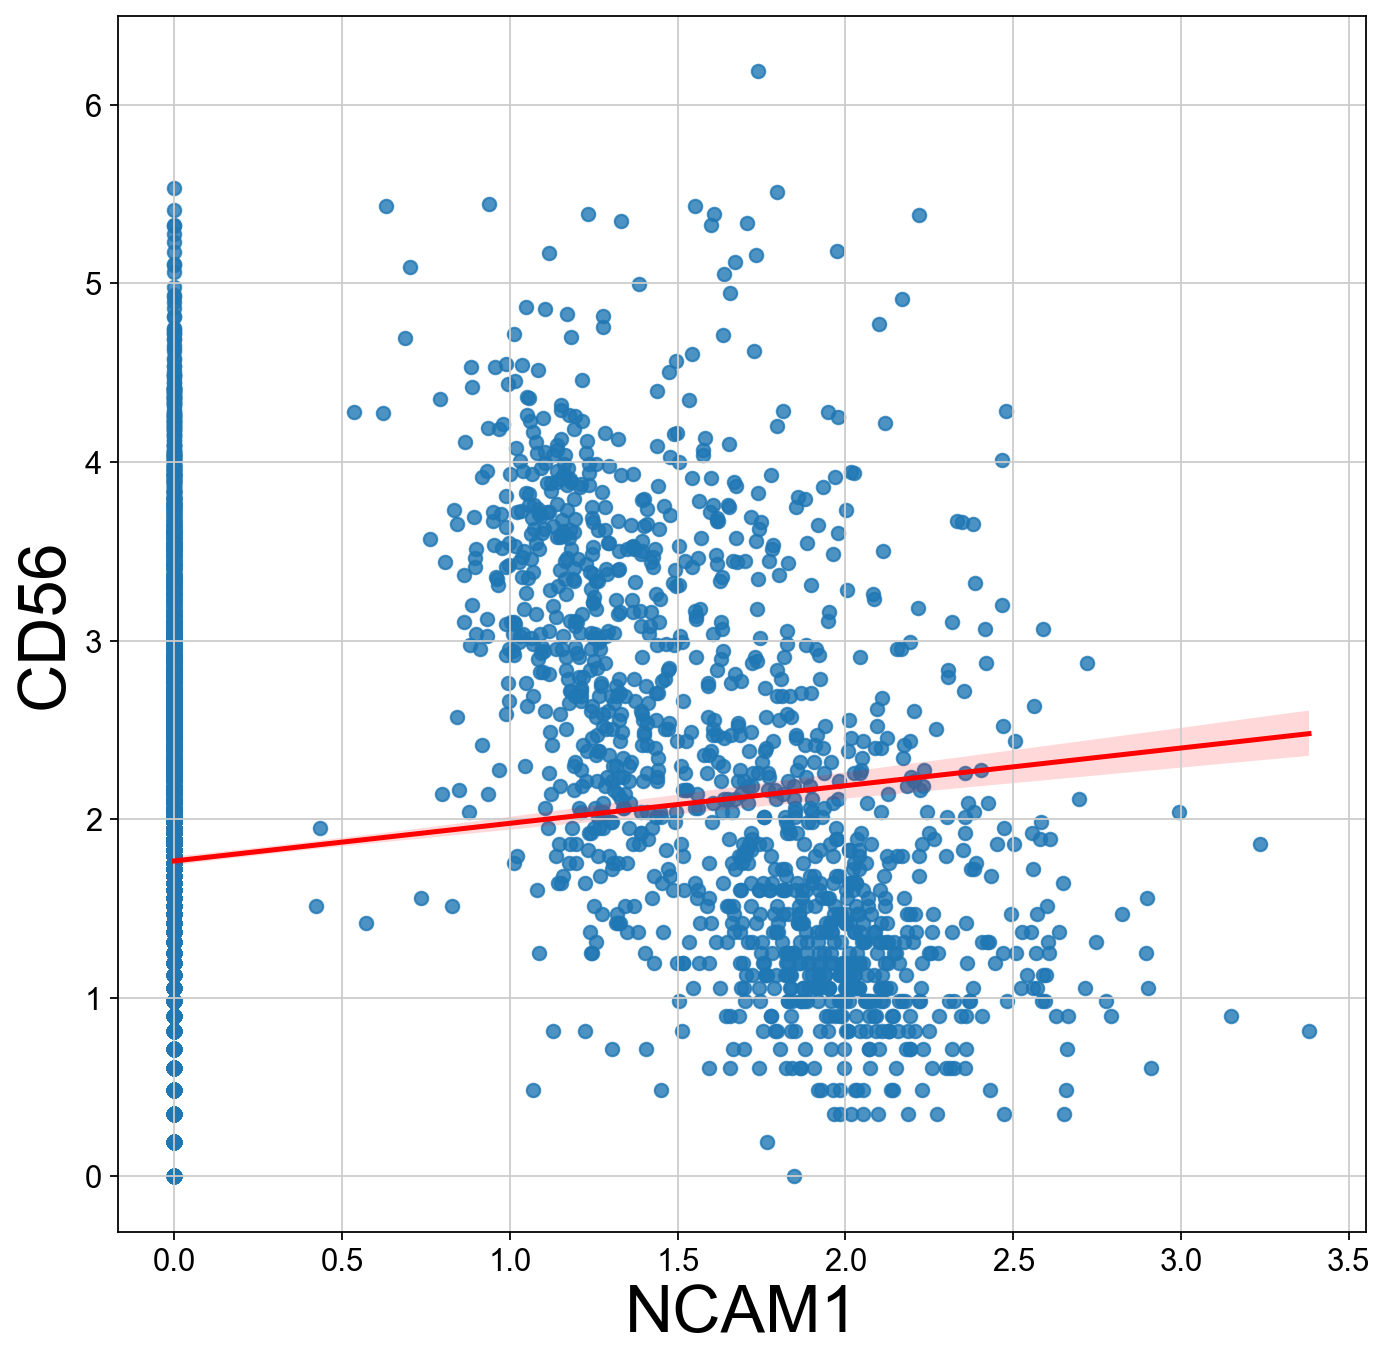

In [188]:
a = sns.regplot(data=df_comb_cd16, x='NCAM1' , y='CD56', 
                line_kws = {"color": "red"})
a.set_ylabel("CD56",fontsize=30)
a.set_xlabel("NCAM1",fontsize=30)